In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd 
import xarray as xr 
import glob 
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import QuantileTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from scipy.ndimage import gaussian_filter
from tensorflow.keras.optimizers import AdamW
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score,
    precision_recall_fscore_support, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [26]:
#load df at t=0hr (cckw crest) to assess kelvin wave strength at the intersection 
df_0h = pd.read_csv('/glade/u/home/sjsharma/CCKW_Project/CNN/CNN_outputs_3km/03_outputs/CNN_config_dataframes/df_for_CNN_TC_3km_0_hrs_after_cckw_cross.csv')

In [27]:
hr =  18

In [28]:
#Load data 

#import relevant pandas df 
df = pd.read_csv(f'/glade/u/home/sjsharma/CCKW_Project/CNN/CNN_outputs_3km/03_outputs/CNN_config_dataframes/df_for_CNN_TC_3km_{hr}_hrs_after_cckw_cross.csv')

#import the raw numpy data 
arr_raw = np.load(f'/glade/u/home/sjsharma/CCKW_Project/CNN/CNN_outputs_3km/03_outputs/numpy_arrays_for_CNN/feature_data_{hr}_hrs_after_CCKW_cross_TC_3km_simulation_combined_resolution_at_0p25_lat_40_pixels_lon_100_pixels.npy')

#Let's cut the array down to size a little bit 
arr = arr_raw[10:30,40:60,:,:]

#import a sample ds that was part of the overall ds list to create arr (to get names of features) 
with open("/glade/u/home/sjsharma/CCKW_Project/CNN/CNN_outputs_3km/03_outputs/numpy_arrays_for_CNN/channel_names_0_hrs_after_CCKW_cross_TC_3km_simulation_combined_resolution_at_0p25_lat_40_pixels_lon_100_pixels.txt", "r") as f:
    variable_list = [line.strip() for line in f]

#Which folder are we going to save the data in? 
save_dir = Path("/glade/u/home/sjsharma/CCKW_Project/CNN/CNN_outputs_3km/04_outputs")


In [29]:
df

,Unnamed: 0,ID,fhr,valid_time,lon_TRACK,lat_TRACK,vor850,day_adj,tc_genesis,lon_track_hov_idx,day_track_hov_idx,cckw_crest_cross,suspect_point,developer,cckw_filteredpr_val,index
0,3,139,132.0,2000-04-04 12:00:00,278.250305,8.123476,3.721673,6.0,0.0,2783.0,24.0,0.0,0.0,1,0.475292,3
1,10,538,252.0,2000-04-09 12:00:00,348.979401,7.293344,1.760105,11.0,0.0,3490.0,44.0,0.0,0.0,0,0.344616,10
2,17,721,300.0,2000-04-11 12:00:00,227.856964,10.519247,3.482259,13.0,0.0,2279.0,52.0,0.0,0.0,1,0.408703,17
3,18,774,312.0,2000-04-12 00:00:00,163.841904,10.901815,5.014958,13.5,0.0,1638.0,54.0,0.0,0.0,1,0.251250,18
4,20,861,360.0,2000-04-14 00:00:00,255.998978,6.274233,2.820303,15.5,0.0,2560.0,62.0,0.0,0.0,0,0.330383,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,225,6203,2964.0,2000-07-31 12:00:00,60.868843,6.696631,3.318257,124.0,0.0,609.0,496.0,0.0,0.0,1,0.469339,225
103,226,6279,3012.0,2000-08-02 12:00:00,87.627769,4.378044,1.907359,126.0,0.0,876.0,504.0,0.0,0.0,0,1.092682,226
104,227,6372,3072.0,2000-08-05 00:00:00,116.127289,7.073828,2.159910,128.5,0.0,1161.0,514.0,0.0,0.0,1,0.333258,227
105,228,6471,3120.0,2000-08-07 00:00:00,136.793060,7.560466,3.332326,130.5,0.0,1368.0,522.0,0.0,0.0,1,0.141789,228


In [30]:
np.shape(arr)

(20, 20, 52, 107)

In [31]:
print(f"after filtering out weak/nonexistent kelvin wave interactions: number of non-developers: {len(df[df['developer'] == 0])}")
print(f"after filtering out weak/nonexistent kelvin waves interactions: number of developers: {len(df[df['developer'] == 1])}")
print(f'total number of filtered (select) samples: {len(df)}')

after filtering out weak/nonexistent kelvin wave interactions: number of non-developers: 73
after filtering out weak/nonexistent kelvin waves interactions: number of developers: 34
total number of filtered (select) samples: 107


In [32]:
# strong_vorticity_threshhold_0hr = 1.5

# strong_devs = df.query('vor850 > @strong_vorticity_threshhold_0hr and developer == 1').index
# weak_devs = df.query('vor850 < @strong_vorticity_threshhold_0hr and developer == 1').index
# strong_nondevs = df.query('vor850 > @strong_vorticity_threshhold_0hr and developer == 0').index
# weak_nondevs = df.query('vor850 < @strong_vorticity_threshhold_0hr and developer == 0').index

In [33]:
# df['vor850'].plot()

In [34]:
#get indices of desired variables 

vars1 = ['olrtoa', 'u10', 'v10','vor850','qv_vint','precipw']
vars_nicer = ['qv_10374.365234375','vor_3056.27294921875','olrtoa','vor850','shrmag','u10']
vars_nicer2 = ['qv_10374.365234375','vor_3056.27294921875','olrtoa','vor850','shrmag','u10']



# Try temperature
# Try exploratory EDA 
# Wake up early and 
desired_vars = vars_nicer3

number_of_features = len(desired_vars)

desired_indices = [i for i,var in enumerate(variable_list) if var in desired_vars]

vor850_idx = [i for i,var in enumerate(variable_list) if var in 'vor850']

In [35]:
X_select_ind = df.index.values
y_select_ind = df['developer'].values

#Train on select samples 
X = X_select_ind
y = y_select_ind


In [36]:
X_train_indices, X_test_indices, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [37]:
pixels = 20

In [38]:
X_train_raw = arr[:,:,:,X_train_indices]
X_train = X_train_raw[:,:,desired_indices,:]

X_test_raw = arr[:,:,:,X_test_indices]
X_test = X_test_raw[:,:,desired_indices,:]


# compute mean and std per variable (channel)
means = X_train.mean(axis=(0,1,3), keepdims=True)   # shape (1,1,1,7)
stds  = X_train.std(axis=(0,1,3), keepdims=True)    # shape (1,1,1,7)

# standardize
X_train_norm = (X_train - means) / stds
X_test_norm = (X_test - means) / stds

In [39]:
print(np.shape(X_train_norm))
print(np.shape(X_test_norm))
print(len(y_train))
print(len(y_test))

(20, 20, 7, 74)
(20, 20, 7, 33)
74
33


In [40]:
from tensorflow.keras import layers, models, optimizers

def build_model(input_shape=(pixels, pixels, number_of_features)):
    inputs = layers.Input(shape=input_shape)

    # Block 1 (stride=1, downsample via MaxPool)
    x = layers.Conv2D(4, 5, strides=1, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)   # 64 -> 32

    # Block 2
    x = layers.Conv2D(8, 3, strides=1, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)   # 32 -> 16

    # Head
    x = layers.GlobalAveragePooling2D()(x)    # very few params vs Flatten+Dense
    x = layers.Dense(8, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=AdamW(learning_rate=2e-3, weight_decay=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


========== Fold 1/5 ==========
Epoch 1/100


2025-11-16 16:02:30.484080: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.3084 - loss: 0.9152 - val_accuracy: 0.3333 - val_loss: 0.8218 - learning_rate: 0.0020
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3084 - loss: 0.8496 - val_accuracy: 0.3333 - val_loss: 0.7878 - learning_rate: 0.0020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3084 - loss: 0.8016 - val_accuracy: 0.3333 - val_loss: 0.7633 - learning_rate: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3084 - loss: 0.7665 - val_accuracy: 0.3333 - val_loss: 0.7446 - learning_rate: 0.0020
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3197 - loss: 0.7416 - val_accuracy: 0.4000 - val_loss: 0.7301 - learning_rate: 0.0020
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3197 - loss: 0.7239 - val_accuracy: 0.4000 - val_loss: 0.7185 - learning_rate: 0.0020
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3632 - loss: 0.7128 - val_accuracy: 0.4000 - va

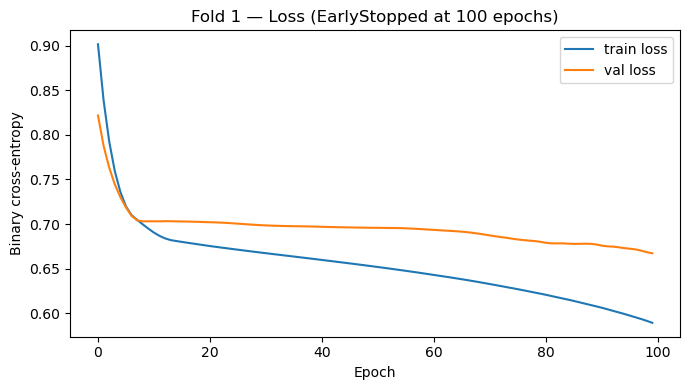

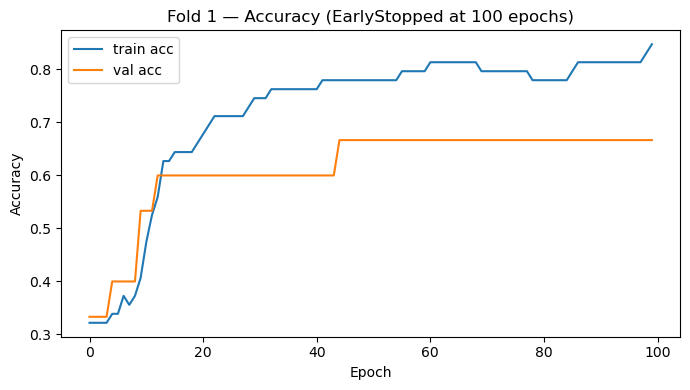

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Fold 1: best validation F1 threshold = 0.45
Fold 1 — Acc: 0.667 | Prec: 0.500 | Rec: 1.000 | F1: 0.667
              precision    recall  f1-score   support

           0      1.000     0.500     0.667        10
           1      0.500     1.000     0.667         5

    accuracy                          0.667        15
   macro avg      0.750     0.750     0.667        15
weighted avg      0.833     0.667     0.667        15



2025-11-16 16:02:42.982719: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


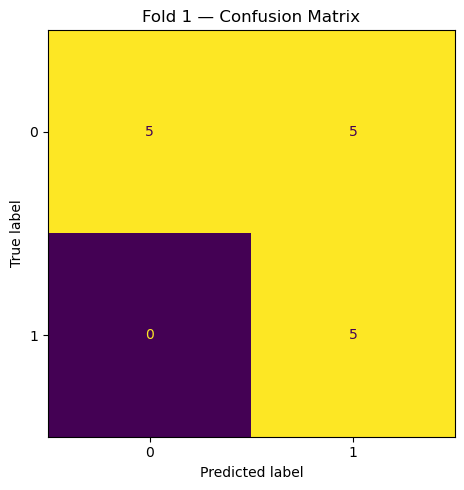


========== Fold 2/5 ==========
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.3189 - loss: 0.8152 - val_accuracy: 0.3333 - val_loss: 0.7247 - learning_rate: 0.0020
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3293 - loss: 0.7413 - val_accuracy: 0.4667 - val_loss: 0.6786 - learning_rate: 0.0020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4944 - loss: 0.6972 - val_accuracy: 0.6000 - val_loss: 0.6490 - learning_rate: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6698 - loss: 0.6669 - val_accuracy: 0.7333 - val_loss: 0.6295 - learning_rate: 0.0020
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6811 - loss: 0.6449 - val_accuracy: 0.6667 - val_loss: 0.6207 - learning_rate: 0.0020
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6811 - loss: 0.6290 - val_accuracy: 0.6667 - val_loss: 0.6091 - learning_rate: 0.0020
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.681

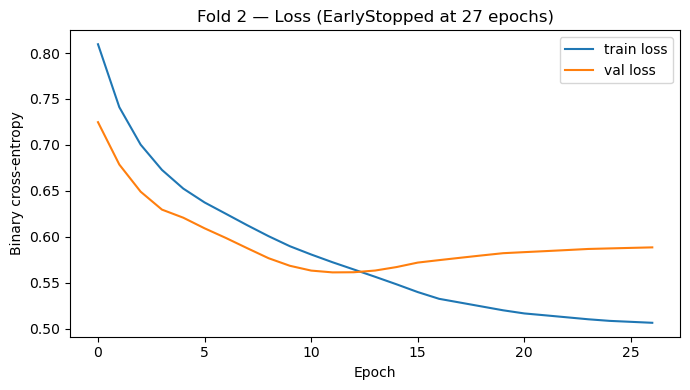

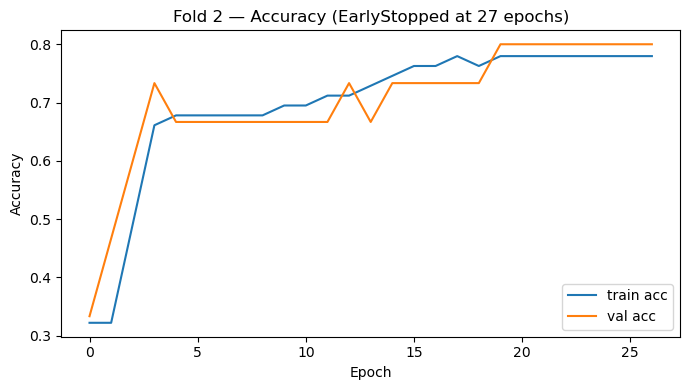

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Fold 2: best validation F1 threshold = 0.40
Fold 2 — Acc: 0.800 | Prec: 0.750 | Rec: 0.600 | F1: 0.667
              precision    recall  f1-score   support

           0      0.818     0.900     0.857        10
           1      0.750     0.600     0.667         5

    accuracy                          0.800        15
   macro avg      0.784     0.750     0.762        15
weighted avg      0.795     0.800     0.794        15



2025-11-16 16:02:48.299513: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


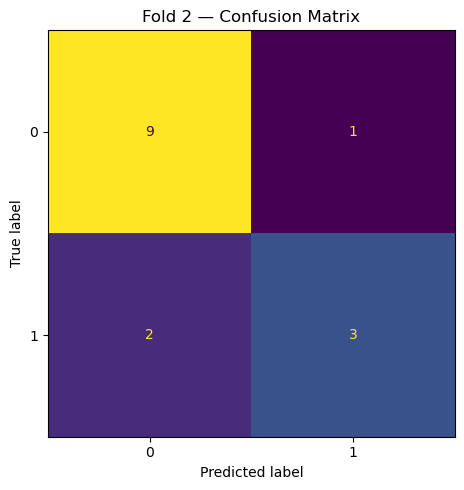


========== Fold 3/5 ==========
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.6594 - loss: 0.6786 - val_accuracy: 0.6667 - val_loss: 0.6561 - learning_rate: 0.0020
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6811 - loss: 0.6566 - val_accuracy: 0.6667 - val_loss: 0.6436 - learning_rate: 0.0020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6811 - loss: 0.6408 - val_accuracy: 0.6667 - val_loss: 0.6339 - learning_rate: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6811 - loss: 0.6273 - val_accuracy: 0.6667 - val_loss: 0.6253 - learning_rate: 0.0020
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6811 - loss: 0.6136 - val_accuracy: 0.6667 - val_loss: 0.6208 - learning_rate: 0.0020
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6811 - loss: 0.5996 - val_accuracy: 0.6667 - val_loss: 0.6218 - learning_rate: 0.0020
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.681

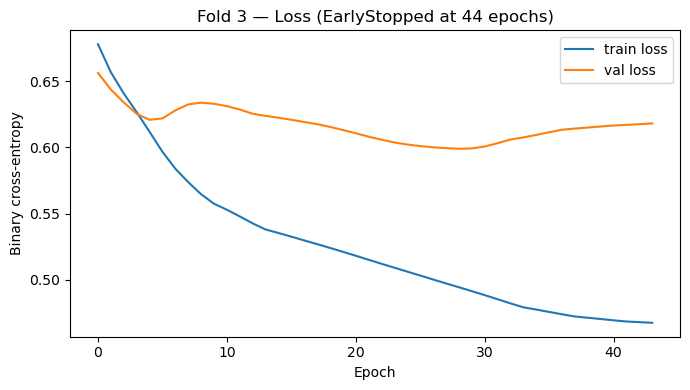

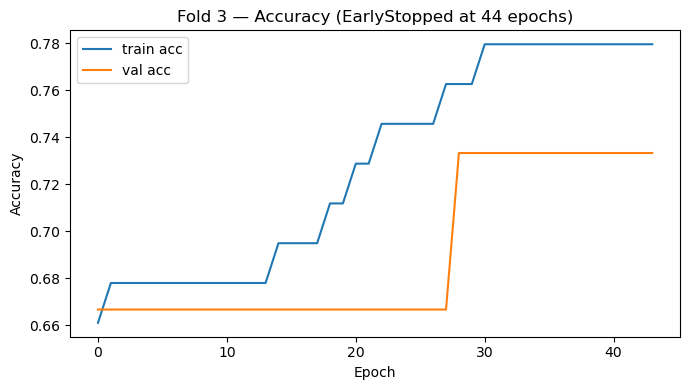

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Fold 3: best validation F1 threshold = 0.30
Fold 3 — Acc: 0.733 | Prec: 0.571 | Rec: 0.800 | F1: 0.667
              precision    recall  f1-score   support

           0      0.875     0.700     0.778        10
           1      0.571     0.800     0.667         5

    accuracy                          0.733        15
   macro avg      0.723     0.750     0.722        15
weighted avg      0.774     0.733     0.741        15



2025-11-16 16:02:55.051865: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


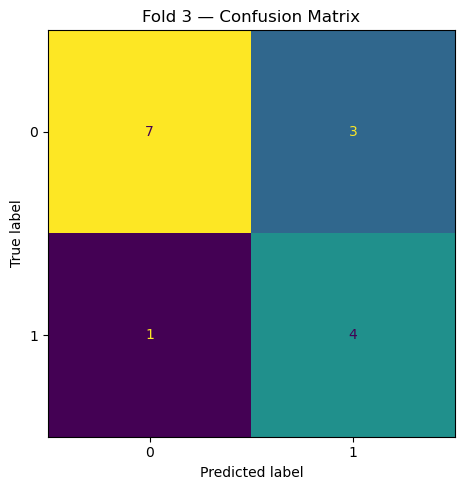


========== Fold 4/5 ==========
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.6707 - loss: 0.6310 - val_accuracy: 0.6667 - val_loss: 0.6371 - learning_rate: 0.0020
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6707 - loss: 0.6003 - val_accuracy: 0.6667 - val_loss: 0.6283 - learning_rate: 0.0020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6707 - loss: 0.5827 - val_accuracy: 0.6667 - val_loss: 0.6266 - learning_rate: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6707 - loss: 0.5685 - val_accuracy: 0.6667 - val_loss: 0.6290 - learning_rate: 0.0020
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6707 - loss: 0.5563 - val_accuracy: 0.6667 - val_loss: 0.6330 - learning_rate: 0.0020
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6707 - loss: 0.5455 - val_accuracy: 0.6667 - val_loss: 0.6361 - learning_rate: 0.0020
Epoch 7/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.656

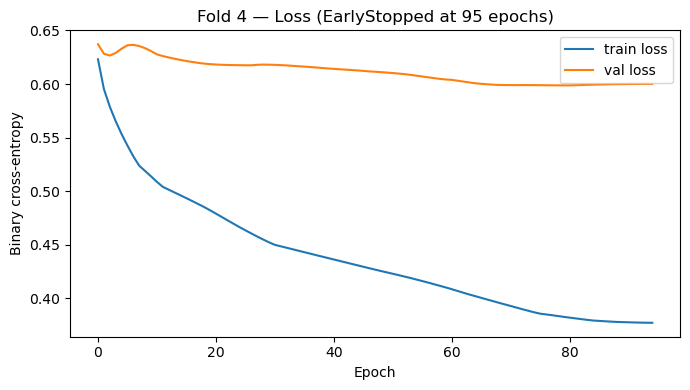

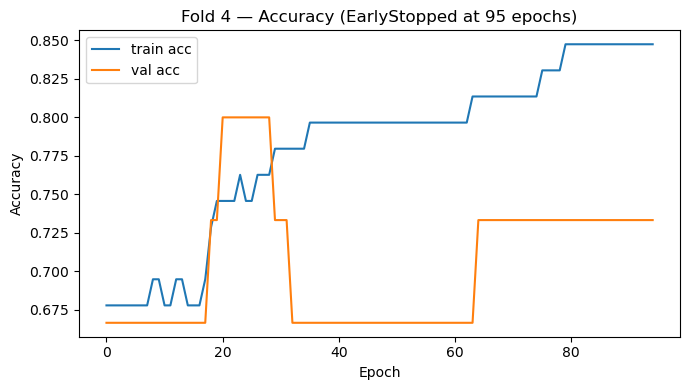

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Fold 4: best validation F1 threshold = 0.50
Fold 4 — Acc: 0.733 | Prec: 0.600 | Rec: 0.600 | F1: 0.600
              precision    recall  f1-score   support

           0      0.800     0.800     0.800        10
           1      0.600     0.600     0.600         5

    accuracy                          0.733        15
   macro avg      0.700     0.700     0.700        15
weighted avg      0.733     0.733     0.733        15



2025-11-16 16:03:07.415890: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


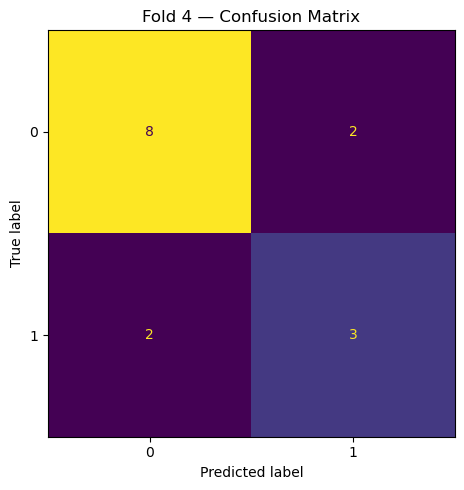


========== Fold 5/5 ==========
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.3368 - loss: 0.8373 - val_accuracy: 0.2857 - val_loss: 0.8275 - learning_rate: 0.0020
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3479 - loss: 0.7673 - val_accuracy: 0.3571 - val_loss: 0.7751 - learning_rate: 0.0020
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4681 - loss: 0.7168 - val_accuracy: 0.4286 - val_loss: 0.7335 - learning_rate: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6090 - loss: 0.6793 - val_accuracy: 0.5714 - val_loss: 0.6974 - learning_rate: 0.0020
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6847 - loss: 0.6483 - val_accuracy: 0.7143 - val_loss: 0.6691 - learning_rate: 0.0020
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7174 - loss: 0.6278 - val_accuracy: 0.7857 - val_loss: 0.6480 - learning_rate: 0.0020
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.684

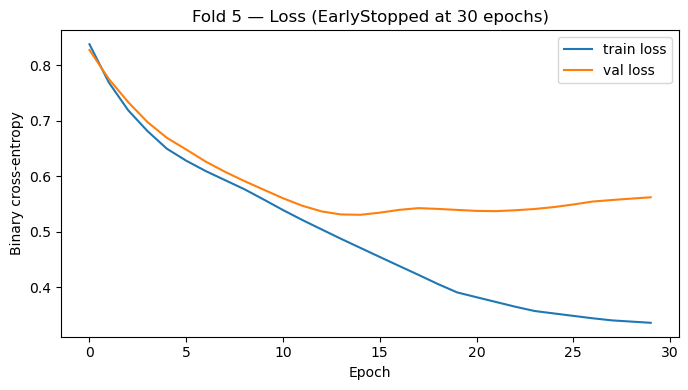

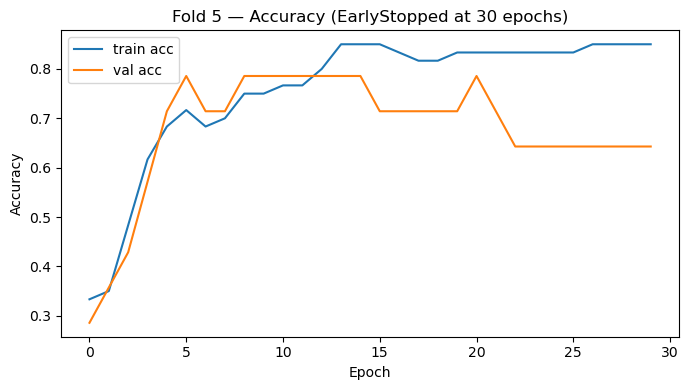

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Fold 5: best validation F1 threshold = 0.35
Fold 5 — Acc: 0.714 | Prec: 0.500 | Rec: 0.750 | F1: 0.600
              precision    recall  f1-score   support

           0      0.875     0.700     0.778        10
           1      0.500     0.750     0.600         4

    accuracy                          0.714        14
   macro avg      0.688     0.725     0.689        14
weighted avg      0.768     0.714     0.727        14



2025-11-16 16:03:13.035153: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


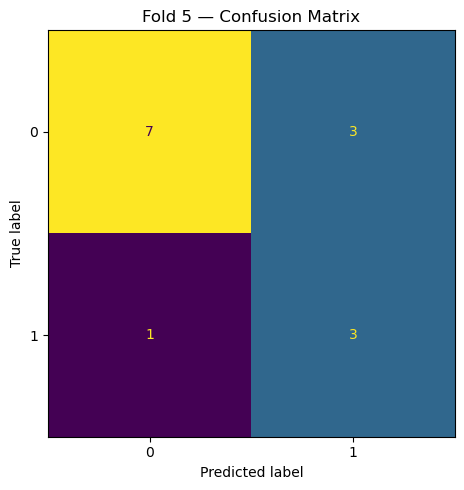

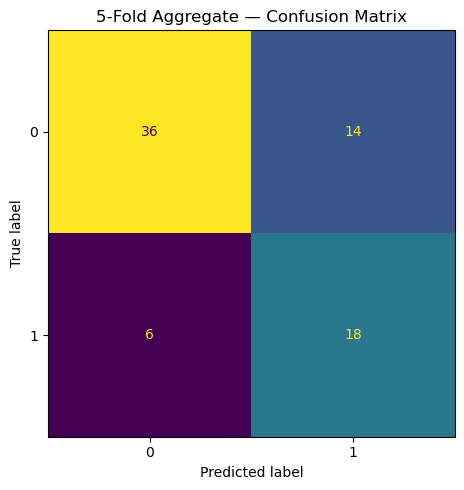


=== 5-Fold Summary ===
Accuracy: mean 0.730 ± 0.043
F1-score: mean 0.640 ± 0.033
Per-fold thresholds: ['0.45', '0.40', '0.30', '0.50', '0.35']


In [41]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW  # if used inside build_model

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, accuracy_score,
                             precision_recall_fscore_support, f1_score)

import os, random, numpy as np, tensorflow as tf

class_weights = {0: 1, 1: 1}
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

# ----------------------------
# 1) Prepare data (NO test set here)
#    data: (H, W, C, N)  → X: (N, H, W, C)
# ----------------------------

X = np.moveaxis(X_train_norm, -1, 0)
y = y_train

N, H, W, C = X.shape
assert y.shape[0] == N, "y must have length equal to number of samples"


skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
EPOCHS   = 100
BATCH    = 32
PATIENCE = 15   # early stopping patience
LR_PAT   = 4      # reduce LR after 4 bad epochs
MIN_LR   = 1e-5

aggregate_cm = np.zeros((2,2), dtype=int)
fold_reports = []

def pick_best_threshold(y_true, y_prob, metric="f1"):
    thr_grid = np.linspace(0.05, 0.95, 19)
    scores = []
    for t in thr_grid:
        yp = (y_prob >= t).astype(int)
        if metric == "f1":
            scores.append(f1_score(y_true, yp))
        else:
            raise NotImplementedError
    return thr_grid[int(np.argmax(scores))]




for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), start=1):
    print(f"\n========== Fold {fold}/5 ==========")
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # Fresh model each fold
    tf.keras.backend.clear_session()
    model = build_model(input_shape=(H, W, C))

    # Callbacks: EarlyStopping (restore best), optional LR reduction
    cbs = [
        EarlyStopping(monitor="val_loss",
                      patience=PATIENCE,
                      restore_best_weights=True,
                      verbose=1),
        ReduceLROnPlateau(monitor="val_loss",
                          factor=0.5,
                          patience=LR_PAT,
                          min_lr=MIN_LR,
                          verbose=1),
    ]

    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=EPOCHS,
        batch_size=BATCH,
        callbacks=cbs,
        verbose=1,
        class_weight=class_weights
    )

    # --- NEW: record how many epochs actually ran ---
    epochs_run = len(hist.history["loss"])
    print(f"Fold {fold} finished after {epochs_run} epochs (early stopping)")

    # Plot curves for this fold
    plt.figure(figsize=(7,4))
    plt.plot(hist.history["loss"], label="train loss")
    plt.plot(hist.history["val_loss"], label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Binary cross-entropy")
    plt.title(f"Fold {fold} — Loss (EarlyStopped at {epochs_run} epochs)")
    plt.legend(); plt.tight_layout(); plt.show()

    if "accuracy" in hist.history:
        plt.figure(figsize=(7,4))
        plt.plot(hist.history["accuracy"], label="train acc")
        plt.plot(hist.history["val_accuracy"], label="val acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title(f"Fold {fold} — Accuracy (EarlyStopped at {epochs_run} epochs)")
        plt.legend(); plt.tight_layout(); plt.show()

    # Predict on validation holdout
    y_prob = model.predict(X_va).ravel()

    # Optional: tune threshold on this fold's validation set (F1)
    best_t = pick_best_threshold(y_va, y_prob, metric="f1")
    print(f"Fold {fold}: best validation F1 threshold = {best_t:.2f}")

    y_pred = (y_prob >= best_t).astype(int)

    # Confusion matrix + metrics
    cm = confusion_matrix(y_va, y_pred, labels=[0,1])
    aggregate_cm += cm

    acc = accuracy_score(y_va, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_va, y_pred, average="binary", zero_division=0
    )

    print(f"Fold {fold} — Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
    print(classification_report(y_va, y_pred, digits=3))

    # Visual CM for this fold
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(f"Fold {fold} — Confusion Matrix")
    plt.tight_layout(); plt.show()

    # --- UPDATED: store epochs_run in fold_reports ---
    fold_reports.append({
        "fold": fold,
        "threshold": float(best_t),
        "acc": float(acc),
        "prec": float(prec),
        "rec": float(rec),
        "f1": float(f1),
        "cm": cm,
        "epochs_run": int(epochs_run)
    })

# Aggregate CM across folds
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay(aggregate_cm, display_labels=[0,1]).plot(ax=ax, values_format="d", colorbar=False)
ax.set_title("5-Fold Aggregate — Confusion Matrix")
plt.tight_layout(); plt.show()

# Print quick aggregate stats
accs = [fr["acc"] for fr in fold_reports]
f1s  = [fr["f1"]  for fr in fold_reports]
print("\n=== 5-Fold Summary ===")
print(f"Accuracy: mean {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1-score: mean {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print("Per-fold thresholds:", [f'{fr["threshold"]:.2f}' for fr in fold_reports])




Mean epochs from 5 folds: 75
Using mean decision threshold from CV: 0.40
Epoch 1/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6894 - loss: 0.7417 
Epoch 2/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6894 - loss: 0.6434
Epoch 3/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6894 - loss: 0.6076
Epoch 4/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6894 - loss: 0.5949
Epoch 5/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6894 - loss: 0.5877
Epoch 6/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6894 - loss: 0.5792
Epoch 7/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6894 - loss: 0.5700
Epoch 8/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6894 - loss: 0.5612
Epoch 9/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6894 - loss: 0.5532
Epoch 10/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6894 - loss: 0.5450
Epoch 11/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6894 - loss: 0.5363
Epoch 12/7

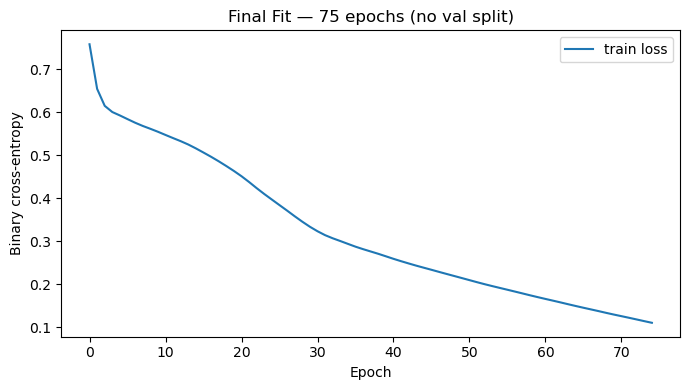

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2025-11-16 16:03:19.112733: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Test Confusion Matrix (labels [0,1] = [Non-genesis, Genesis]):
 [[21  2]
 [ 5  5]]
Test — Acc: 0.788 | Prec: 0.714 | Rec: 0.500 | F1: 0.588
              precision    recall  f1-score   support

           0      0.808     0.913     0.857        23
           1      0.714     0.500     0.588        10

    accuracy                          0.788        33
   macro avg      0.761     0.707     0.723        33
weighted avg      0.779     0.788     0.776        33



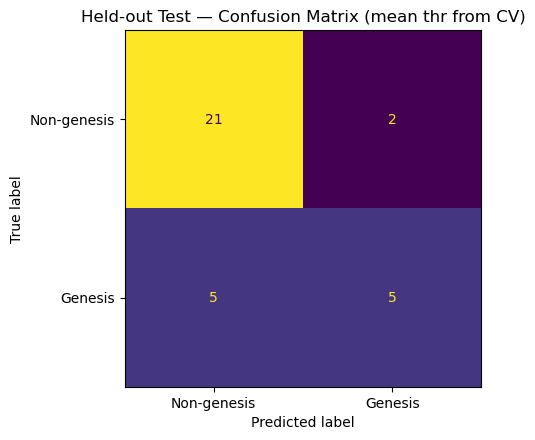

Test positives predicted: 7 of 33
Test probability range — min: 9.668256e-08  max: 0.999956  mean: 0.17780526


In [42]:
# --- 0) Mean epochs & mean threshold from CV ---
thr_cv = float(np.mean([fr["threshold"] for fr in fold_reports]))
epochs_run = [fr["epochs_run"] for fr in fold_reports]
final_epochs = int(np.round(np.mean(epochs_run)))

final_epochs = 75

print(f"\nMean epochs from 5 folds: {final_epochs}")
print(f"Using mean decision threshold from CV: {thr_cv:.2f}")

# --- 1) Prepare arrays (same preprocessing as CV; do NOT touch test stats) ---
X_tr_all = np.moveaxis(X_train_norm, -1, 0)   # (N_train, H, W, C)
y_tr_all = y_train

X_te = np.moveaxis(X_test_norm, -1, 0)        # (N_test, H, W, C)
y_te = y_test

Ntr, H, W, C = X_tr_all.shape   # derive shape from TRAIN, not test

# --- 2) Retrain final model on ALL training data
#         • NO validation split
#         • Run for exactly 'final_epochs'
#         • No callbacks that monitor val_loss
# ------------------------------------------------
tf.keras.backend.clear_session()
final_model = build_model(input_shape=(H, W, C))

history_final = final_model.fit(
    X_tr_all, y_tr_all,
    epochs=final_epochs,
    batch_size=32,      # or BATCH if defined above
    shuffle=True,
    verbose=1,
    class_weight=class_weights
)

# (Optional) visualize training loss only
plt.figure(figsize=(7,4))
plt.plot(history_final.history["loss"], label="train loss")
plt.xlabel("Epoch"); plt.ylabel("Binary cross-entropy")
plt.title(f"Final Fit — {final_epochs} epochs (no val split)")
plt.legend(); plt.tight_layout(); plt.show()

# --- 3) Predict on held-out test set (use mean threshold from CV) -----------
y_prob_te = final_model.predict(X_te).ravel()
y_pred_te = (y_prob_te >= thr_cv).astype(int)   # mean threshold

# --- 4) Confusion matrix & metrics -----------------------------------------
cm_te = confusion_matrix(y_te, y_pred_te, labels=[0,1])
print("Test Confusion Matrix (labels [0,1] = [Non-genesis, Genesis]):\n", cm_te)

acc = accuracy_score(y_te, y_pred_te)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_te, y_pred_te, average="binary", zero_division=0
)
print(f"Test — Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
print(classification_report(y_te, y_pred_te, digits=3))

fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay(cm_te, display_labels=["Non-genesis","Genesis"]).plot(
    ax=ax, values_format="d", colorbar=False
)
ax.set_title("Held-out Test — Confusion Matrix (mean thr from CV)")
plt.tight_layout(); plt.show()

# (Optional) quick sanity checks
print("Test positives predicted:", int((y_pred_te==1).sum()), "of", len(y_pred_te))
print("Test probability range — min:", y_prob_te.min(), " max:", y_prob_te.max(), " mean:", y_prob_te.mean())


Test — ROC–AUC: 0.726 | PR–AUC: 0.634


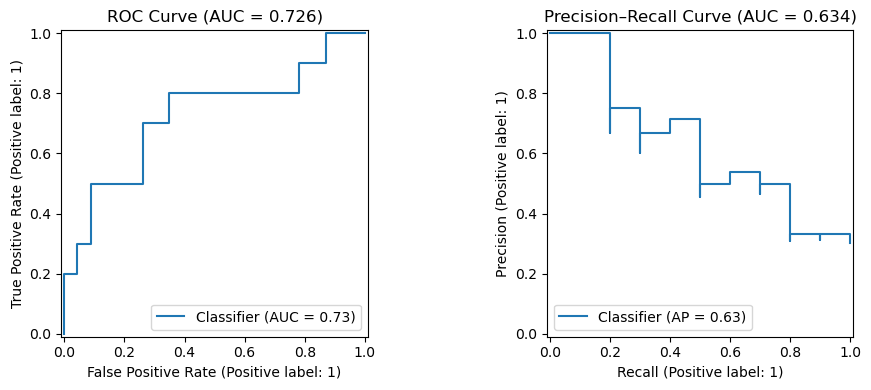

In [43]:
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

# --- 4b) AUC metrics ---
roc_auc = roc_auc_score(y_te, y_prob_te)
pr_auc = average_precision_score(y_te, y_prob_te)
print(f"Test — ROC–AUC: {roc_auc:.3f} | PR–AUC: {pr_auc:.3f}")

# --- 4c) Optional plots ---
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ROC curve
RocCurveDisplay.from_predictions(y_te, y_prob_te, ax=ax[0])
ax[0].set_title(f"ROC Curve (AUC = {roc_auc:.3f})")

# Precision–Recall curve
PrecisionRecallDisplay.from_predictions(y_te, y_prob_te, ax=ax[1])
ax[1].set_title(f"Precision–Recall Curve (AUC = {pr_auc:.3f})")

plt.tight_layout()
plt.show()